# Import Data & Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import fastai
import numpy as np
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.vision.learner import *
from fastai.vision.models.unet import *

In [ ]:
# Image classification dataset
path = untar_data(URLs.CIFAR)

In [ ]:
# If use own dataset
# animals = 'Bears', 'Foxes', 'Wolves' 
# path = '/content/drive/MyDrive/Implementation/FastAI'
# fns = get_image_files(path)
# fns

(#283) [Path('/content/drive/MyDrive/Implementation/FastAI/Wolves/Gray-wolf.jpg'),Path('/content/drive/MyDrive/Implementation/FastAI/Wolves/Gray-timber-wolf.jpg'),Path('/content/drive/MyDrive/Implementation/FastAI/Wolves/10cli-wolves-mobileMasterAt3x.jpg'),Path('/content/drive/MyDrive/Implementation/FastAI/Wolves/gray-wolf-closeup_2x3.jpg'),Path('/content/drive/MyDrive/Implementation/FastAI/Wolves/Kolmården_Wolf.jpg'),Path('/content/drive/MyDrive/Implementation/FastAI/Wolves/Eurasian_wolf_2.jpg'),Path('/content/drive/MyDrive/Implementation/FastAI/Wolves/wolves-in-the-snow.jpg'),Path('/content/drive/MyDrive/Implementation/FastAI/Wolves/MAIN_BLOG_IMG_Grey-WOlf-1800x1200.jpg'),Path('/content/drive/MyDrive/Implementation/FastAI/Wolves/gray-wolf_thumb_square.jpg'),Path('/content/drive/MyDrive/Implementation/FastAI/Wolves/gettyimages-1184378069_web.jpg')...]

# Image Classification

## Data Loading

In [ ]:
# Data augmentation
def custom_augmentations():
    return [Flip(p=0.5), 
            Rotate(max_deg=20), 
            Zoom(max_zoom=1.1)]

item_tfms = [Resize(128)] # Resize images
batch_tfms = [*custom_augmentations(), Normalize.from_stats(*imagenet_stats)] # batch transformation

In [ ]:
# Data loader
img = DataBlock(blocks=(ImageBlock, CategoryBlock), # Pass information to data loaders class about the kind of data
                 get_items = get_image_files, # How the data loaders class will get the data
                 splitter = RandomSplitter(valid = test, seed = 42),  # How the validation set is to be created
                 get_y = parent_label, # How to get the labels for our data set
                 item_tfms = item_tfms, 
                 batch_tfms = batch_tfms 
)

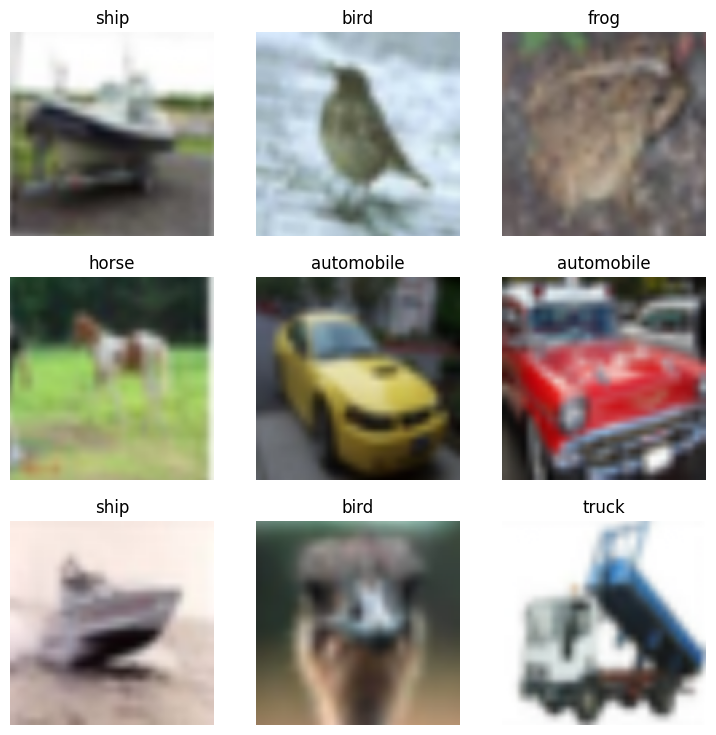

In [ ]:
dls = img.dataloaders(path, bs=64)
dls.show_batch()

## Model

In [ ]:
# Create learner
learn = vision_learner(dls, resnet34, metrics = accuracy)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 355MB/s]


In [ ]:
# Train model
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.587982,0.369197,0.873667,02:09


epoch,train_loss,valid_loss,accuracy,time
0,0.289386,0.209152,0.930000,02:20
1,0.223921,0.173148,0.942667,02:25
2,0.153072,0.149024,0.952417,02:23
3,0.085867,0.124371,0.960500,02:30
4,0.045199,0.117354,0.963000,02:43


In [ ]:
# Evaluate model
learn.validate()

(#2) [0.11735361814498901,0.9629999995231628]

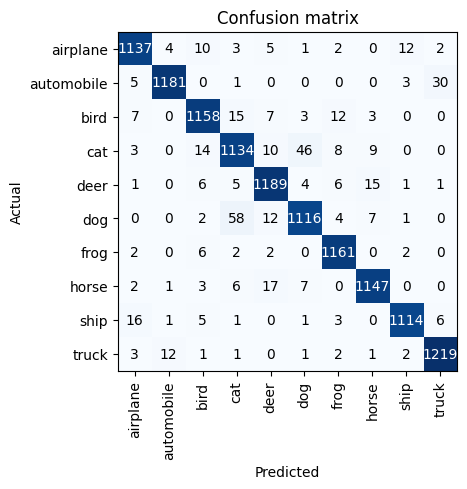

In [ ]:
# Plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

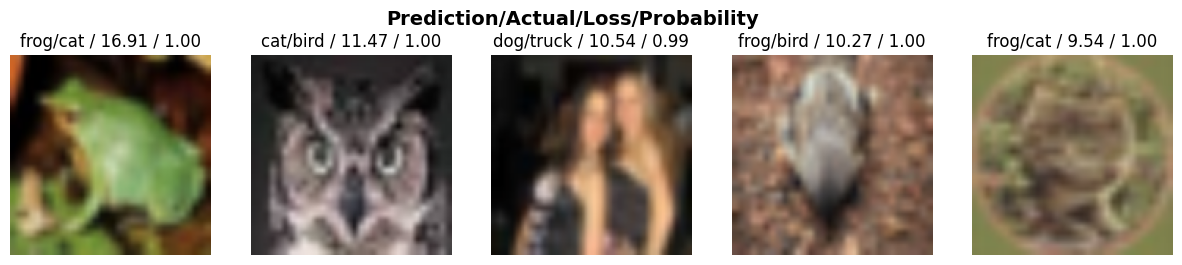

In [ ]:
# Shows the images with the highest losses
interp.plot_top_losses(5, nrows=1)

In [ ]:
# Saving model for use
learn.export()
path = Path()
# Checks model which has the file extension '.pkl' is present in path
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Application Setup

In [ ]:
# Loads model into 'learn_inf'
learn_inf = load_learner(path/'export.pkl')
# Access our data loaders for the prediction classes
learn_inf.dls.vocab

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# Create button
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
# Test the 'btn_upload' button by feeding it an image to upload
btn_upload = SimpleNamespace(data = ['/content/drive/MyDrive/Implementation/FastAI/Test/airplane.jpg'])

In [ ]:
# Creates an output widget
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
# Use of the output widget to display the image fed to out upload button
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
# Make a predition for img
# predicted output, index of the predicted class among the group of probable classes,probability of the predicted output
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
# Creates a label widget which is used to display output
lbl_pred = widgets.Label()
# Arrange the format in which output would be displayed
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: airplane; Probability: 0.9948')

In [ ]:
# Creates another widget which would use as classify button
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

## Inference

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your image!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

# Image Segmentation

In [ ]:
# Image segmentation dataset
path_seg = untar_data(URLs.CAMVID)

## Data loading

<Axes: >

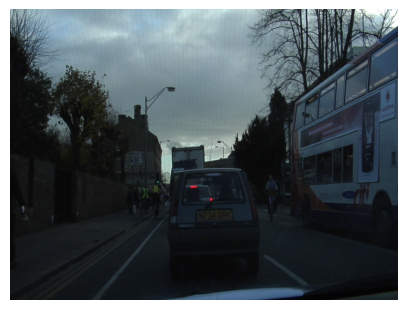

In [ ]:
path_img = path_seg/'images'
path_lbl = path_seg/'labels'

fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

<Axes: >

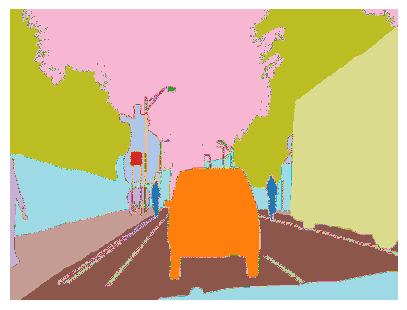

In [ ]:
def get_msk(o):
    return path_seg/'labels'/f'{o.stem}_P{o.suffix}'

msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [ ]:
codes = np.loadtxt(path_seg/'codes.txt', dtype=str); codes

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

In [ ]:
len(codes)

32

In [ ]:
# Data augmentation
item_tfms = [Resize(128)] # Resize images
batch_tfms = [*aug_transforms(), Normalize.from_stats(*imagenet_stats)] # batch transformation

In [ ]:
# Data loader
imgseg = DataBlock(blocks=(ImageBlock, MaskBlock(codes)), # Pass information to data loaders class about the kind of data
                   get_items=get_image_files, # How the data loaders class will get the data
                   get_y = get_msk,
                   splitter=FileSplitter(path_seg/'valid.txt'), # How the validation set is to be created
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms
                  )

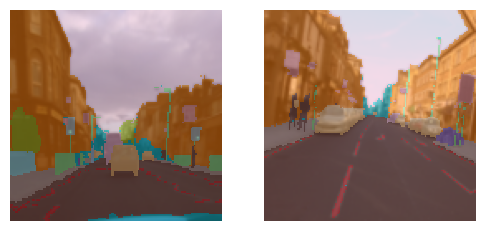

In [ ]:
dls = imgseg.dataloaders(path_seg/'images', bs=2)
dls.show_batch()

In [ ]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics=acc_camvid # accuracy

## Model

In [ ]:
learn = unet_learner(dls, resnet34, metrics = metrics, self_attention=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.079072,1.285916,0.623319,00:38


epoch,train_loss,valid_loss,acc_camvid,time
0,0.673156,0.619021,0.845175,00:36


In [ ]:
# Evaluate model
learn.validate()

(#2) [0.6190208196640015,0.8451749682426453]

In [ ]:
# Saving model for use
learn.export()
path = Path()
# Checks model which has the file extension '.pkl' is present in path
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Inference

In [ ]:
# Loads model into 'learn_inf'
learn_inf = load_learner(path/'export.pkl')

In [ ]:
img = PILImage.create('/content/drive/MyDrive/Implementation/FastAI/Test/test.png')

<Axes: >

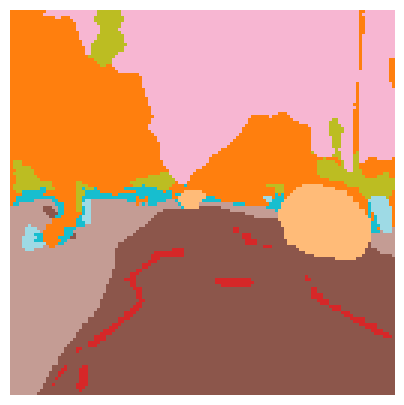

In [ ]:
pred = learn_inf.predict(img)
pred[0].show(figsize=(5,5), alpha=1)

In [ ]:
from IPython.display import clear_output

# Create the widgets for the user interface
btn_upload = widgets.FileUpload()
btn_segment = widgets.Button(description='Segment')
out_pl = widgets.Output()

# Define the function to handle the button click event
def on_segment_click(btn):
    # 讀取上傳的圖片
    img = PILImage.create(btn_upload.data[-1])
    # 切割圖片並顯示結果
    with out_pl:
        clear_output()
        pred = learn_inf.predict(img)
        pred[0].show(figsize=(5,5), alpha=1)

# Attach the click event handler to the button
btn_segment.on_click(on_segment_click)

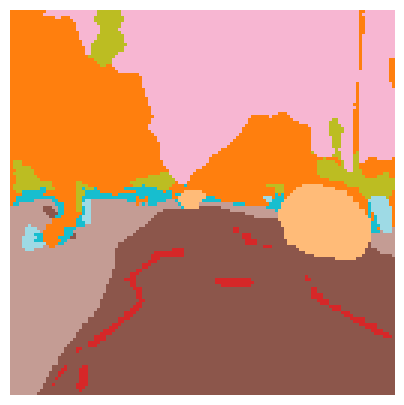

In [ ]:
# Display the widgets
VBox([widgets.Label('Select your image!'), 
      btn_upload, btn_segment, out_pl])